# ENSO

This notebook plots ENSO against surface area in a few different ways. Can we figure out which climate driver affects which waterbodies?

## Setup

### Load modules

In [2]:
import sys

import cmocean.cm
import datacube
import geopandas as gpd
import matplotlib.animation
import matplotlib.colors
import matplotlib.patches
import numpy as np
import scipy.cluster
import scipy.ndimage.filters
import sklearn.cluster
import sklearn.decomposition
import sklearn.pipeline
import sklearn.preprocessing
import statsmodels.tsa.stattools
from matplotlib import pyplot as plt
from scipy import optimize as opt
from tqdm.notebook import tqdm
import pandas as pd

sys.path.insert(1, "../Scripts")
import dea_plotting

%matplotlib widget

### Load the data

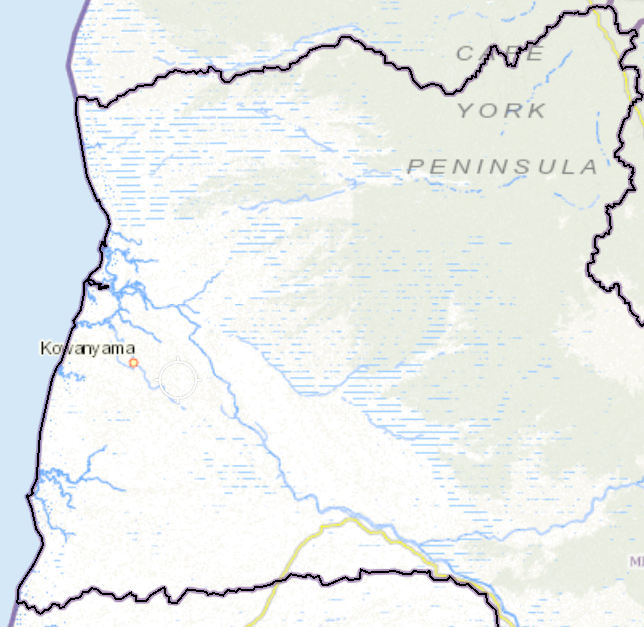

This was generated in WaterbodyClustering.ipynb.

In [98]:
# history = np.load("history_Mitchell-Coleman_full.npy")
# times = np.load("time_axis_Mitchell-Coleman_full.npy").astype("datetime64[D]")
# waterbodies = gpd.read_file("waterbodies_Mitchell-Coleman.geojson")

history = np.load("history_murray_full.npy")
times = np.load("time_axis_murray_full.npy").astype("datetime64[D]")
waterbodies = gpd.read_file("waterbodies_murray.geojson")

In [126]:
# data = scipy.ndimage.filters.gaussian_filter1d(history, sigma=7, axis=1)
data = history.copy()

In [128]:
data /= 100

In [106]:
grad = np.diff(data)

MemoryError: Unable to allocate 1.16 GiB for an array with shape (12535, 12388) and data type float64

In [129]:
times_ = times[:-1]

In [130]:
mean = data.mean(axis=0)

In [131]:
plt.figure()
plt.plot(times, mean)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
%%bash
wget https://data.longpaddock.qld.gov.au/SeasonalClimateOutlook/SouthernOscillationIndex/SOIDataFiles/DailySOI1933-1992Base.csv

Unload all python modules, if you experience any issues.
--2020-09-09 11:21:06--  https://data.longpaddock.qld.gov.au/SeasonalClimateOutlook/SouthernOscillationIndex/SOIDataFiles/DailySOI1933-1992Base.csv
Resolving data.longpaddock.qld.gov.au... 13.35.145.108, 13.35.145.40, 13.35.145.75, ...
Connecting to data.longpaddock.qld.gov.au|13.35.145.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243015 (237K) [text/x-comma-separated-values]
Saving to: `DailySOI1933-1992Base.csv.1'

     0K .......... .......... .......... .......... .......... 21% 17.6M 0s
    50K .......... .......... .......... .......... .......... 42% 13.2M 0s
   100K .......... .......... .......... .......... .......... 63% 13.2M 0s
   150K .......... .......... .......... .......... .......... 84% 12.0M 0s
   200K .......... .......... .......... .......              100% 16.1M=0.02s

2020-09-09 11:21:06 (14.0 MB/s) - `DailySOI1933-1992Base.csv.1' saved [243015/243015]



In [110]:
soi = pd.read_csv('DailySOI1933-1992Base.csv')

In [111]:
soi_dates = []
for s in soi.itertuples():
    soi_dates.append(pd.Timestamp(year=s.Year, day=1, month=1) + pd.Timedelta(s.Day, unit='D'))

In [112]:
soi_dates = np.array(soi_dates)
soi['Date'] = soi_dates

In [113]:
plt.figure()
plt.hist(soi.SOI)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([4.400e+01, 1.110e+03, 5.247e+03, 1.496e+03, 2.200e+01, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-76.05 , -45.961, -15.872,  14.217,  44.306,  74.395, 104.484,
        134.573, 164.662, 194.751, 224.84 ]),
 <a list of 10 Patch objects>)

## Plotting SOI-divided surface area duration curves

In [116]:
ts = pd.DataFrame(data.T).set_index(times)

In [117]:
ts = ts.join(soi.set_index('Date'))

In [118]:
ts = ts[~ts.index.duplicated(keep='first')].reset_index()

In [119]:
ts['SOI_rolling'] = ts.SOI.rolling(28).mean()

In [132]:
el_nino = ts.SOI_rolling < -8
la_nina = ts.SOI_rolling > 8
neutral = ~el_nino & ~la_nina

In [133]:
plt.figure()
plt.plot(np.linspace(0, 1, sum(el_nino)), np.sort(mean[el_nino])[::-1], label='El Niño', c='firebrick')
plt.plot(np.linspace(0, 1, sum(neutral)), np.sort(mean[neutral])[::-1], label='Neutral', c='grey')
plt.plot(np.linspace(0, 1, sum(la_nina)), np.sort(mean[la_nina])[::-1], label='La Niña', c='steelblue')
plt.xlabel('Cumulative % time')
plt.ylabel('Surface area')
plt.legend()

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [134]:
mean_sad_el_nino = np.sort(mean[el_nino])[::-1]
mean_sad_neutral = np.sort(mean[neutral])[::-1]
mean_sad_la_nina = np.sort(mean[la_nina])[::-1]

quantiles_el_nino = np.percentile(mean_sad_el_nino, np.arange(100))
quantiles_neutral = np.percentile(mean_sad_neutral, np.arange(100))
quantiles_la_nina = np.percentile(mean_sad_la_nina, np.arange(100))

In [136]:
plt.figure()
plt.scatter(quantiles_el_nino, quantiles_neutral, marker='x')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--', c='grey')
plt.xlabel('El Nino')
plt.ylabel('Neutral')

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Neutral')

In [137]:
plt.figure()
plt.scatter(quantiles_la_nina, quantiles_neutral, marker='x')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--', c='grey')
plt.xlabel('La Nina')
plt.ylabel('Neutral')

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Neutral')

In [138]:
recent = np.zeros_like(el_nino)
recent[-365 * 5:] = 1

In [139]:
diffs_el_nino = []
diffs_la_nina = []
for wb in tqdm(data):
    quantiles_el_nino_ = np.percentile(wb[el_nino & recent], np.arange(100))
    quantiles_neutral_ = np.percentile(wb[neutral & recent], np.arange(100))
    quantiles_la_nina_ = np.percentile(wb[la_nina & recent], np.arange(100))
    diff_el_nino = np.sqrt(((quantiles_el_nino_ - quantiles_neutral_) ** 2).sum()) / 2
    diff_la_nina = np.sqrt(((quantiles_la_nina_ - quantiles_neutral_) ** 2).sum()) / 2
    diffs_el_nino.append(diff_el_nino)
    diffs_la_nina.append(diff_la_nina)

In [140]:
permanence = np.mean(data[:, -365 * 5:], axis=1)

In [146]:
len(waterbodies), len(permanence), len(quantiles_el_nino)

(12535, 12535, 100)

In [156]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
waterbodies.geometry.plot(ax=ax, color=matplotlib.cm.Reds(diffs_el_nino))

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [157]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
waterbodies.geometry.plot(ax=ax, color=matplotlib.cm.Blues(diffs_la_nina))

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [167]:
rgb = np.stack([
    diffs_el_nino,
    np.ones_like(diffs_el_nino),
    diffs_la_nina,
]).T

In [168]:
rgb = rgb / rgb.max()

In [169]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
waterbodies.geometry.plot(ax=ax, color=rgb)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [153]:
plt.figure()
plt.subplot(1, 2, 1)
plt.scatter(waterbodies.centroid.x, waterbodies.centroid.y, c=diffs_el_nino, s=permanence ** 2 * 100, cmap='Reds')
plt.subplot(1, 2, 2)
plt.scatter(waterbodies.centroid.x, waterbodies.centroid.y, c=diffs_la_nina, s=permanence ** 2 * 100, cmap='Blues')

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [91]:
import mattplot
z_en = mattplot.spatial_average(waterbodies.centroid.x, waterbodies.centroid.y, np.array(diffs_el_nino), progress=tqdm, k=5)

../Scripts/mattplot.py:26: RuntimeWarning: invalid value encountered in true_divide
  return total / count


In [92]:
plt.figure()
plt.imshow(z_en, origin='lower')

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Let's get the SAD curves for each waterbody.

In [21]:
phases = {
    'El Niño': el_nino,
    'La Niña': la_nina,
    'Neutral': neutral,
}

In [22]:
sad = {phase: np.sort(data[:, phases[phase]], axis=1) for phase in phases}

Stretch them to ditch the full/empty periods.

In [23]:
sad_ = {}
for phase in phases:
    firsts = (sad[phase] == 1).argmax(axis=1)
    lasts = (sad[phase] == 0).argmax(axis=1)
    # Argmax is zero if there are no lasts.
    lasts = np.where(lasts == 0, sad[phase].shape[1], lasts)
    ss = []
    for first, last, s in zip(firsts, lasts, sad[phase]):
        s = s[first:last]
        s = np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(s)), s)
        ss.append(s)
    sad_[phase] = np.array(ss)
sad = sad_

For each time step, plot the surface area.

In [25]:
def spatial_average_time(xs: 'n', ys: 'n', values_over_time: 't x n', k=15, progress=tqdm, resolution=500):
    from scipy.spatial import cKDTree

    points = np.stack([xs, ys]).T
    tree = cKDTree(points)
    distances, neighbours = tree.query(points, k=k)
    distances = distances[:, -1]
    X, Y = np.meshgrid(
        np.linspace(xs.min(), xs.max(), resolution), np.linspace(ys.min(), ys.max(), resolution)
    )
    
    n_times = values_over_time.shape[0]
    
    total = np.zeros((1,) + X.shape)
    count = np.zeros((n_times,) + X.shape)
    if progress:
        points = progress(points)
    for (x, y), r, neighbour in zip(points, distances, neighbours):
        circle = ((X - x) ** 2 + (Y - y) ** 2) < r ** 2

        total[0, circle] += 1
        count[:, circle] += values_over_time[:, neighbour].mean(axis=1)[:, None]

    return count / total

In [26]:
sad_sats = {phase: spatial_average_time(waterbodies.centroid.x, waterbodies.centroid.y, sad[phase].T) for phase in sad}

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [30]:
# fig = plt.Figure(figsize=(15, 6))
# gs = fig.add_gridspec(nrows=2, ncols=3)
# a = fig.add_subplot(gs[0, 0])
# b = fig.add_subplot(gs[0, 1])
# c = fig.add_subplot(gs[0, 2])
# d = fig.add_subplot(gs[1, :])
# a_im = a.imshow(sad_sats['El Niño'][0], cmap='Blues', vmin=0, vmax=1)
# a.set_title('El Niño')
# b_im = b.imshow(sad_sats['Neutral'][0], cmap='Blues', vmin=0, vmax=1)
# b.set_title('Neutral')
# c_im = c.imshow(sad_sats['La Niña'][0], cmap='Blues', vmin=0, vmax=1)
# c.set_title('La Niña')
# d_pl = {phase: d.plot(np.linspace(0, 1, 100), sad[phase].mean(axis=0)) for phase in phases}
# d_line = d.axvline(0)

# def update(t):
#     if t >= 100:
#         t = 99 - (t - 100)
#     a_im.set_data(sad_sats['El Niño'][t])
#     b_im.set_data(sad_sats['Neutral'][t])
#     c_im.set_data(sad_sats['La Niña'][t])
#     d_line.set_xdata([t / 100, t / 100])

# ani = matplotlib.animation.FuncAnimation(fig, update, frames=range(200))

## ENSO means

What is the mean water level for each waterbody in each phase of ENSO?

In [91]:
means_el_nino = data[:, el_nino].mean(axis=1)
means_la_nina = data[:, la_nina].mean(axis=1)
means_neutral = data[:, neutral].mean(axis=1)

In [92]:
plt.figure()
bins = np.linspace(0, 1, 100)
plt.hist(means_el_nino, color='firebrick', bins=bins, alpha=0.3)
plt.hist(means_neutral, color='grey', bins=bins, alpha=0.3)
plt.hist(means_la_nina, color='steelblue', bins=bins, alpha=0.3);

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [104]:
el_nino_spatial = dea_plotting.spatial_average(waterbodies.centroid.x, waterbodies.centroid.y, means_el_nino)

../Scripts/dea_plotting.py:1436: RuntimeWarning: invalid value encountered in true_divide


In [105]:
la_nina_spatial = dea_plotting.spatial_average(waterbodies.centroid.x, waterbodies.centroid.y, means_la_nina)

In [106]:
neutral_spatial = dea_plotting.spatial_average(waterbodies.centroid.x, waterbodies.centroid.y, means_neutral)

In [108]:
fig, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
a.imshow(el_nino_spatial, cmap='Blues', vmin=0, vmax=1)
a.set_title('El Niño')
b.imshow(neutral_spatial, cmap='Blues', vmin=0, vmax=1)
b.set_title('Neutral')
c.imshow(la_nina_spatial, cmap='Blues', vmin=0, vmax=1)
c.set_title('La Niña')

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'La Niña')